# Process Mining for Email Workflow

After data has been gathered, Process Mining is executed to check if the concept is valid and every interesting part of the process can be mined / observed.

Use the 'pm4py' library to create a process mining model of a demo log.
The goal is to be able to identify issues in the EMail workflow logs with process mining.

## Features
  * case id   --> 'case:concept:name'
  * timestamp --> 'time:timestamp'
  * activity  --> 'concept:name'
  * resource  --> 'org:resource'

## Process Mining Tools:
   - Alpha Miner
   - Petri Nets
   - Directly Follows Graph (time factor)
   - Replay
   - Diagnostics 

In [274]:
import os
import pm4py

import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
from pm4py.algo.discovery.correlation_mining import algorithm as correlation_miner
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics

from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

from pm4py.algo.conformance.tokenreplay.diagnostics import root_cause_analysis
from pm4py.visualization.decisiontree import visualizer as dt_vis
from pm4py.algo.conformance.alignments import algorithm as alignments

In [275]:
class ProcessMining:
    def __init__(self):
        self._event_log = None

    def print(self, show_slice_list = True) -> None:
        if(show_slice_list):
            print(self._event_log[0:5])
        else:
            print(self._event_log)

    def convert_to_xes(self, _csv_file_name: str, _xes_file_name: str) -> None:
        # parse csv to xes log file
        log_csv = pd.read_csv(_csv_file_name, sep=',')
        log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
        log_csv = log_csv.sort_values('time:timestamp')
        self._event_log = log_converter.apply(log_csv, variant=log_converter.Variants.TO_EVENT_LOG)
        xes_exporter.apply(self._event_log, _xes_file_name)
        
    def get_event_log(self, file_path) -> None: 
        log = xes_importer.apply(file_path)
        self._event_log = log
                                
        
    def alpha_miner(self) -> None:
        net, initial_marking, final_marking = alpha_miner.apply(self._event_log)
        print("Alpha Miner succeeded!")
        
    def alignments(self) -> None:
        net, initial_marking, final_marking = inductive_miner.apply(self._event_log)
        aligned_traces = alignments.apply_log(self._event_log, net, initial_marking, final_marking)
        print(aligned_traces)
        
    def generate_petri_net_alpha_plus(self) -> None:
        petri_net, initial_marking, final_marking = pm4py.discover_petri_net_alpha_plus(self._event_log)
        pm4py.view_petri_net(petri_net, initial_marking, final_marking, format='png')
        pm4py.save_vis_petri_net(petri_net, initial_marking, final_marking, "petri_net.png")
    
    def directly_follows_graph(self) -> None:
        dfg, start_activities, end_activities = pm4py.discover_dfg(self._event_log)
        pm4py.view_dfg(dfg, start_activities, end_activities, format='png', log=self._event_log)
        pm4py.save_vis_dfg(dfg, start_activities, end_activities, "directly_follows_graph.png", 
                           log=self._event_log)
    
    def frequency_performance_graph(self) -> None:
        df = pd.read_csv('./out/long_correlator_case.csv')
        df = dataframe_utils.convert_timestamp_columns_in_df(df)
        df = df[["concept:name", "time:timestamp"]]
        
        frequency_dfg, performance_dfg = correlation_miner.apply(df, 
            parameters={correlation_miner.Variants.CLASSIC.value.Parameters.ACTIVITY_KEY: "concept:name",
            correlation_miner.Variants.CLASSIC.value.Parameters.TIMESTAMP_KEY: "time:timestamp"})
        activities_freq = dict(df["concept:name"].value_counts())
        gviz_freq = dfg_visualizer.apply(frequency_dfg, variant=dfg_visualizer.Variants.FREQUENCY, 
                                         activities_count=activities_freq, parameters={"format": "png"})
        gviz_perf = dfg_visualizer.apply(performance_dfg, variant=dfg_visualizer.Variants.PERFORMANCE, 
                                         activities_count=activities_freq, parameters={"format": "png"})
        print("Frequency: ")
        dfg_visualizer.view(gviz_freq)
        dfg_visualization.save(gviz_freq, "frequency_dfg.png")
        print("Performance: ")
        dfg_visualizer.view(gviz_perf)
        dfg_visualization.save(gviz_perf, "performance_dfg.png")
        
    
    def process_replay(self) -> None:
        # conformance alignments
        # petri_net, initial_marking, final_marking = pm4py.discover_petri_net_alpha_plus(self._event_log)
        # aligned_traces = pm4py.conformance_alignments(self._event_log, petri_net, initial_marking, final_marking)
        #print(aligned_traces)
        
         # token based replay
        parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, 
                          token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
        replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(self._event_log,
                                                                                    net, initial_marking,
                                                                                    final_marking,
                                                                                    parameters=parameters_tbr)
        print(place_fitness)
        
    
    def print_diagnostics(self) -> None:
        parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, 
                          token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
        replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(
                                                                            self._event_log, net,
                                                                            initial_marking,
                                                                            final_marking,
                                                                            parameters=parameters_tbr)
        # throughput analysis
        print(" Throughput Analysis: ")
        trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(self._event_log, trans_fitness)
        for trans in trans_diagnostics:
            print(trans, trans_diagnostics[trans])
            
    def root_cause_analysis(self) -> None:
        parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: False, 
                          token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
        replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(
                                                                            self._event_log, net,
                                                                            initial_marking,
                                                                            final_marking,
                                                                            parameters=parameters_tbr)
        trans_root_cause = root_cause_analysis.diagnose_from_trans_fitness(self._event_log, trans_fitness)
        for trans in trans_root_cause:
            clf = trans_root_cause[trans]["clf"]
            feature_names = trans_root_cause[trans]["feature_names"]
            classes = trans_root_cause[trans]["classes"]
            # visualization could be called
            gviz = dt_vis.apply(clf, feature_names, classes)
            dt_vis.view(gviz)


## 1. Long Correlator Case

In [276]:
mine1 = ProcessMining()

In [277]:
# Scenario 1
mine1.convert_to_xes(_csv_file_name='./out/long_correlator_case.csv',
                     _xes_file_name='./out/long_correlator_case.xes')
mine1.get_event_log('./out/long_correlator_case.xes')
mine1.print(show_slice_list=True)

exporting log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

[{'attributes': {'concept:name': 54}, 'events': [{'time:timestamp': datetime.datetime(2021, 1, 12, 17, 18, 0, 431256, tzinfo=datetime.timezone.utc), 'concept:name': 'executed pre function of component auth_proxy', 'org:resource': 'auth_proxy'}, '..', {'time:timestamp': datetime.datetime(2021, 1, 12, 17, 18, 5, 31256, tzinfo=datetime.timezone.utc), 'concept:name': 'executed post function of component guardia_api', 'org:resource': 'guardia_api'}]}, {'attributes': {'concept:name': 76}, 'events': [{'time:timestamp': datetime.datetime(2021, 1, 12, 17, 18, 0, 626463, tzinfo=datetime.timezone.utc), 'concept:name': 'executed pre function of component auth_proxy', 'org:resource': 'auth_proxy'}, '..', {'time:timestamp': datetime.datetime(2021, 1, 12, 17, 18, 10, 126463, tzinfo=datetime.timezone.utc), 'concept:name': 'executed post function of component guardia_api', 'org:resource': 'guardia_api'}]}, {'attributes': {'concept:name': 106}, 'events': [{'time:timestamp': datetime.datetime(2021, 1, 12

In [278]:
# Alpha Miner
mine1.alpha_miner()

Alpha Miner succeeded!


In [279]:
# Alignments
mine1.alignments()

[{'alignment': [('>>', None), ('>>', None), ('executed pre function of component auth_proxy', 'executed pre function of component auth_proxy'), ('executed pre function of component guardia_api', 'executed pre function of component guardia_api'), ('executed pre function of component email_service', 'executed pre function of component email_service'), ('executed pre function of component indicator_parser', 'executed pre function of component indicator_parser'), ('executed pre function of component worker', 'executed pre function of component worker'), ('executed pre function of component workflow_engine', 'executed pre function of component workflow_engine'), ('executed pre function of component analytics', 'executed pre function of component analytics'), ('executed pre function of component correlator', 'executed pre function of component correlator'), ('executed pre function of component notification_service', 'executed pre function of component notification_service'), ('executed post 

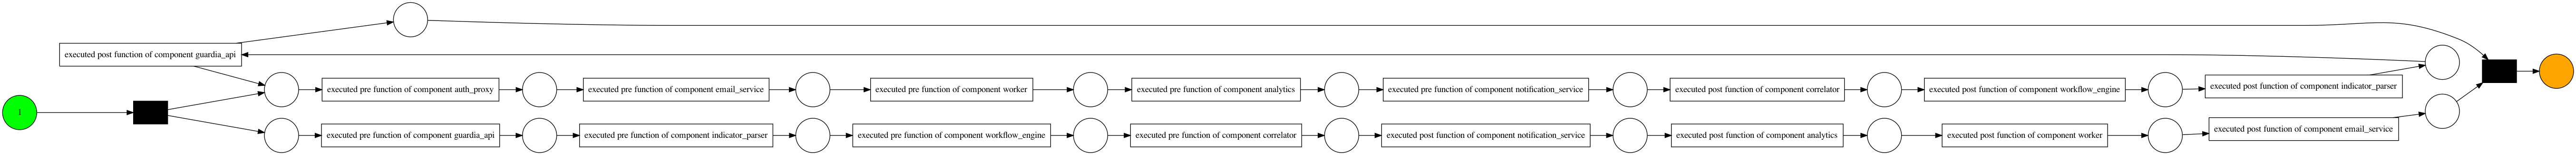

In [280]:
# Discovers a Petri net using the Alpha+ algorithm
mine1.generate_petri_net_alpha_plus()

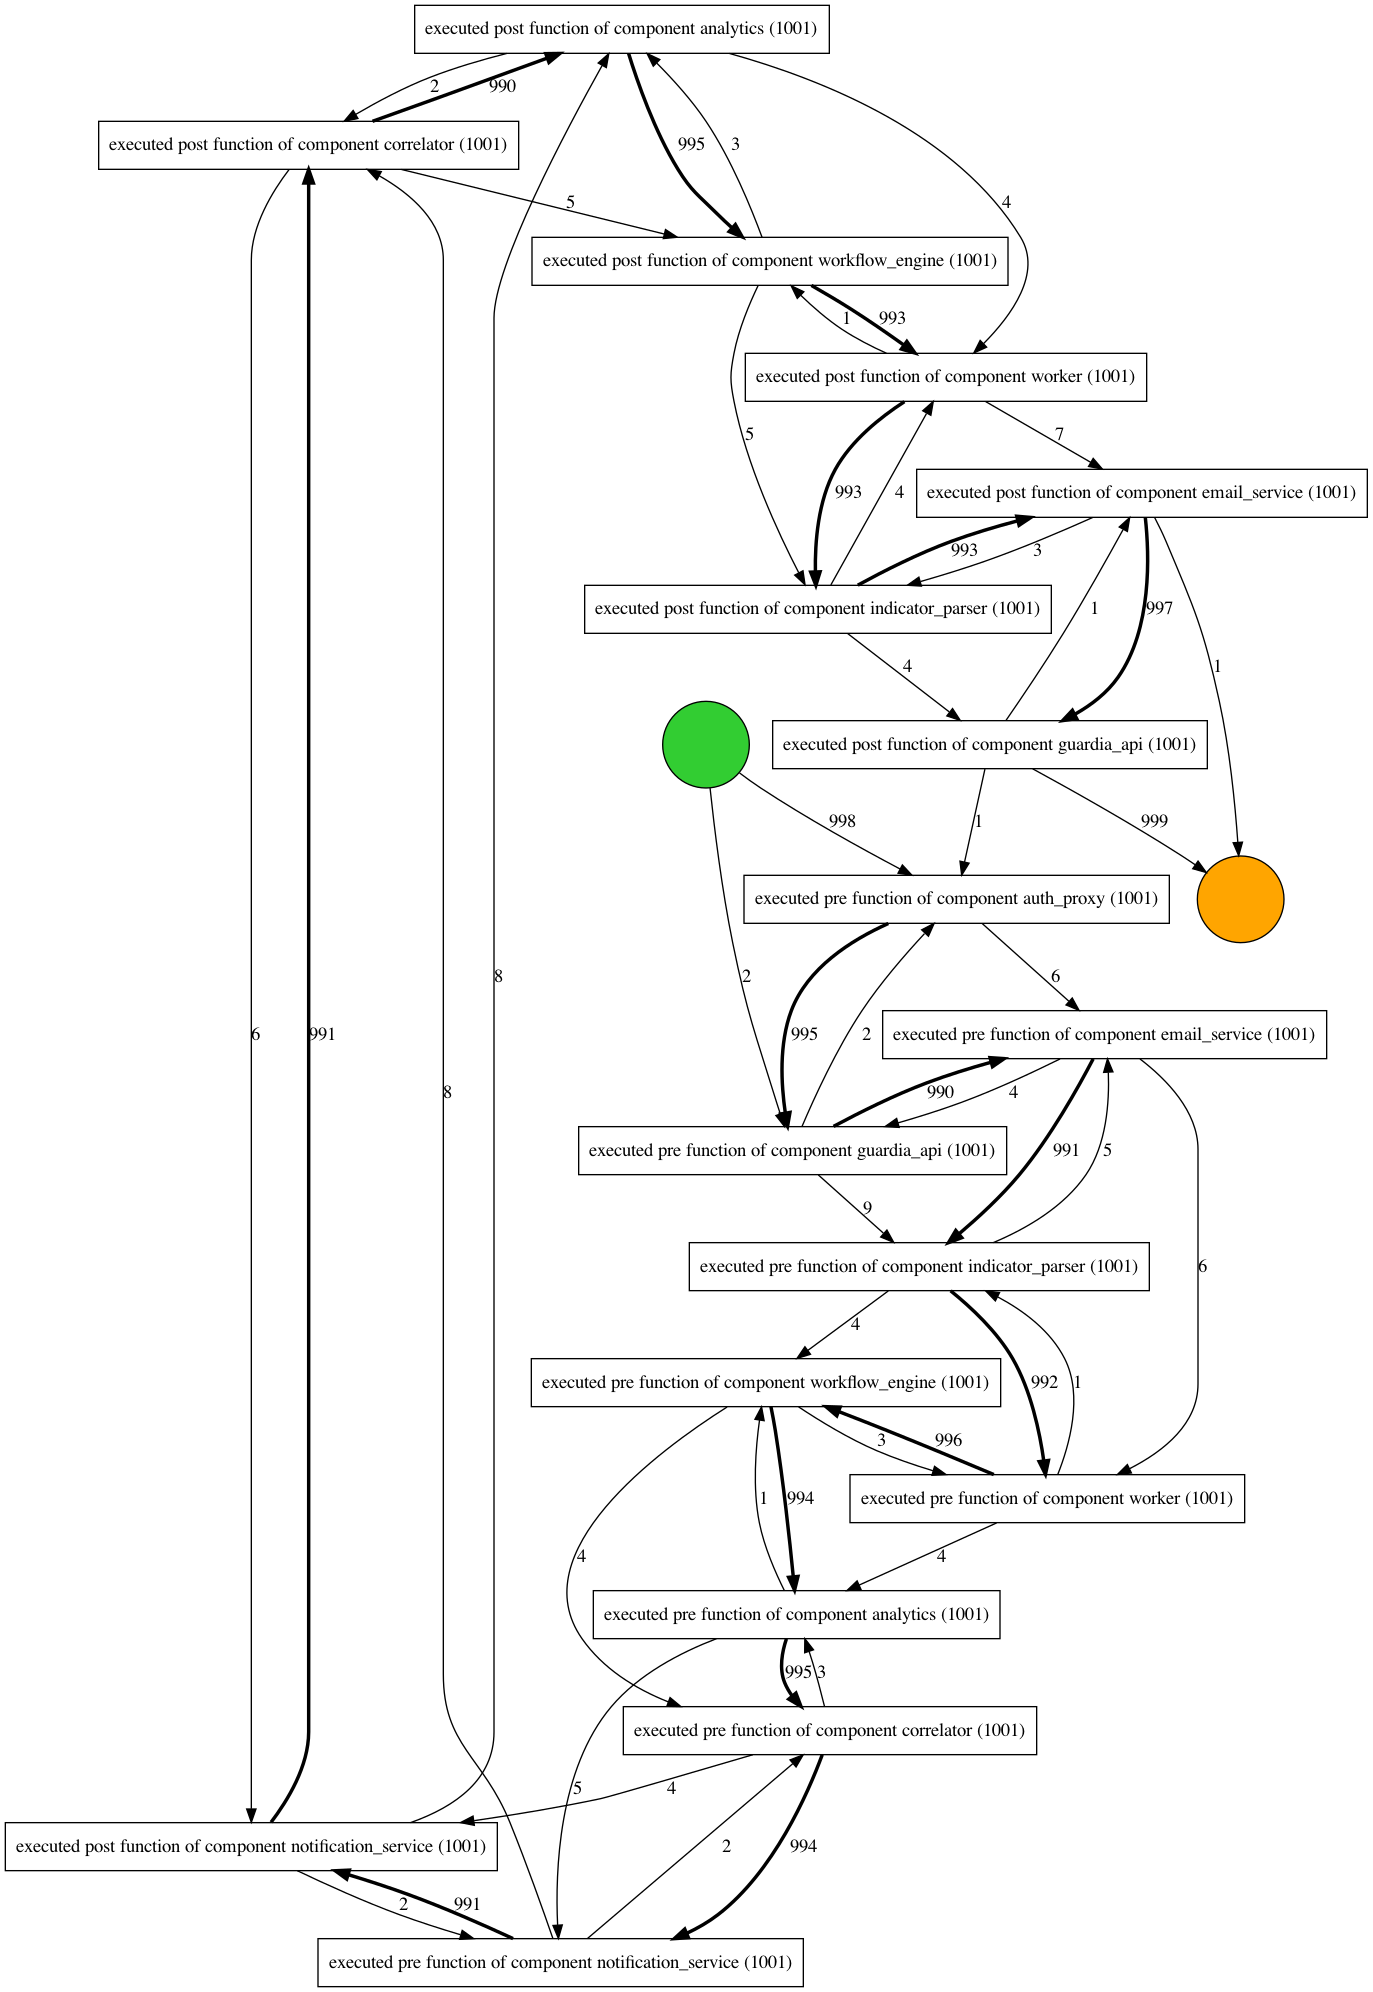

In [281]:
# Discovers a DFG from a log
mine1.directly_follows_graph()

Frequency: 


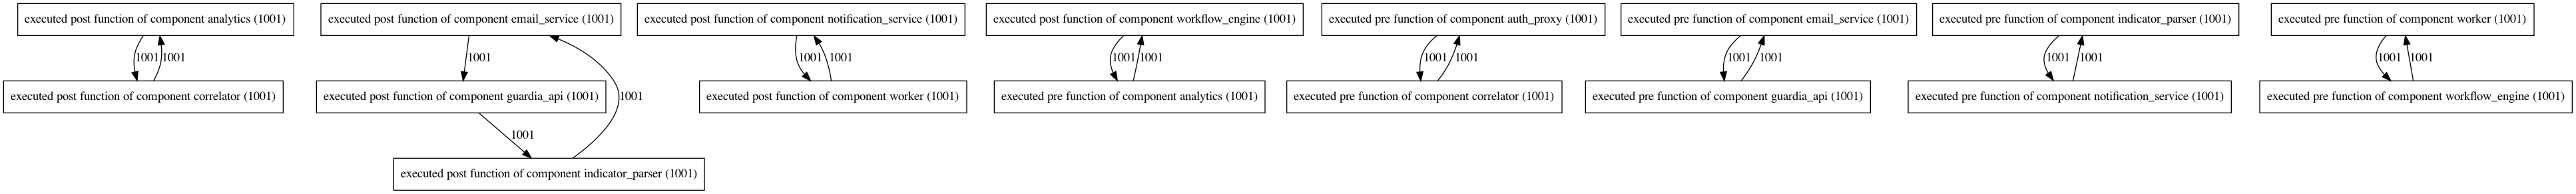

Performance: 


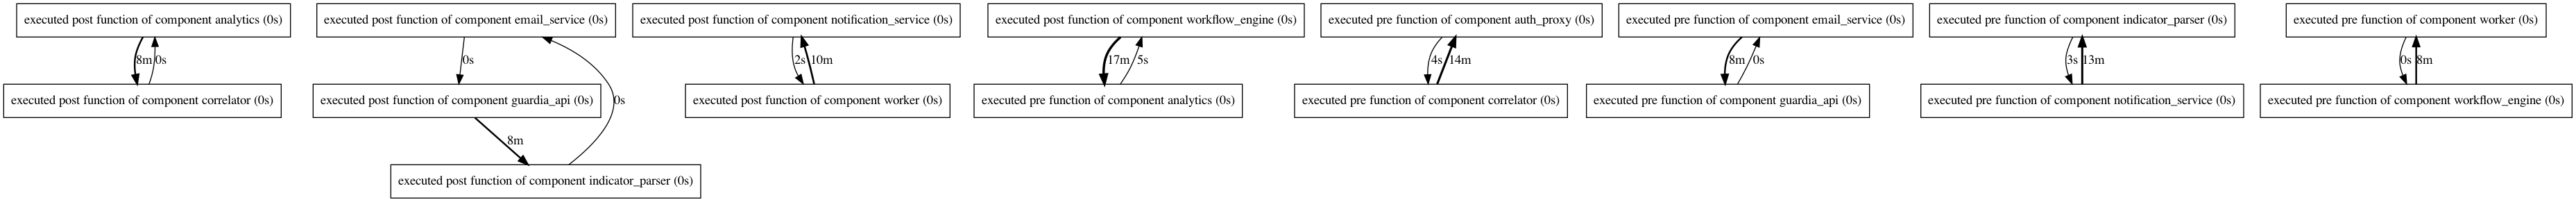

In [282]:
# Performance Graph
mine1.frequency_performance_graph()

In [283]:
# Process Replay
mine1.process_replay()

{({'executed post function of component indicator_parser'}, {'executed post function of component guardia_api'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed pre function of component workflow_engine'}, {'executed pre function of component correlator'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed pre function of component correlator'}, {'executed post function of component notification_service'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, ({'executed post function of component correlator'}, {'executed post function of component workflow_engine'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1001, 'p': 1001}, start: {'underfed_traces': {{'attributes': {'concept:name': 104}, 'events': [{'time:timestamp': datetime.datetime(2021, 1, 12, 17, 18, 6, 525546, tzinfo=datetime.timezone.utc), 'concept:n

In [284]:
# Diagnostics
mine1.print_diagnostics()

 Throughput Analysis: 
executed pre function of component guardia_api {'n_fit': 2, 'n_underfed': 998, 'fit_median_time': 4.85, 'underfed_median_time': 6.8, 'relative_throughput': 1.4020618556701032}


In [285]:
# Root Cause Analysis
# mine.root_cause_analysis()

-----

## 2. Long Correlator-Worker Case

In [286]:
mine2 = ProcessMining()

In [287]:
# Scenario 2
mine2.convert_to_xes(_csv_file_name='./out/long_correlator_worker_case.csv',
                     _xes_file_name='./out/long_correlator_worker_case.xes')
mine2.get_event_log('./out/long_correlator_worker_case.xes')
mine2.print(show_slice_list=True)

exporting log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

[{'attributes': {'concept:name': 0}, 'events': [{'time:timestamp': datetime.datetime(2021, 1, 18, 18, 23, 45, 12778, tzinfo=datetime.timezone.utc), 'concept:name': 'executed pre function of component auth_proxy', 'org:resource': 'auth_proxy'}, '..', {'time:timestamp': datetime.datetime(2021, 1, 18, 18, 47, 36, 206092, tzinfo=datetime.timezone.utc), 'concept:name': 'executed pre function of component indicator_parser', 'org:resource': 'indicator_parser'}]}, {'attributes': {'concept:name': 1}, 'events': [{'time:timestamp': datetime.datetime(2021, 1, 18, 18, 23, 48, 74387, tzinfo=datetime.timezone.utc), 'concept:name': 'executed pre function of component auth_proxy', 'org:resource': 'auth_proxy'}, '..', {'time:timestamp': datetime.datetime(2021, 1, 18, 18, 47, 39, 282767, tzinfo=datetime.timezone.utc), 'concept:name': 'executed post function of component guardia_api', 'org:resource': 'guardia_api'}]}, {'attributes': {'concept:name': 4}, 'events': [{'time:timestamp': datetime.datetime(2021

In [288]:
# Alpha Miner
mine2.alpha_miner()

Alpha Miner succeeded!


In [290]:
# Alignments
mine2.alignments()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



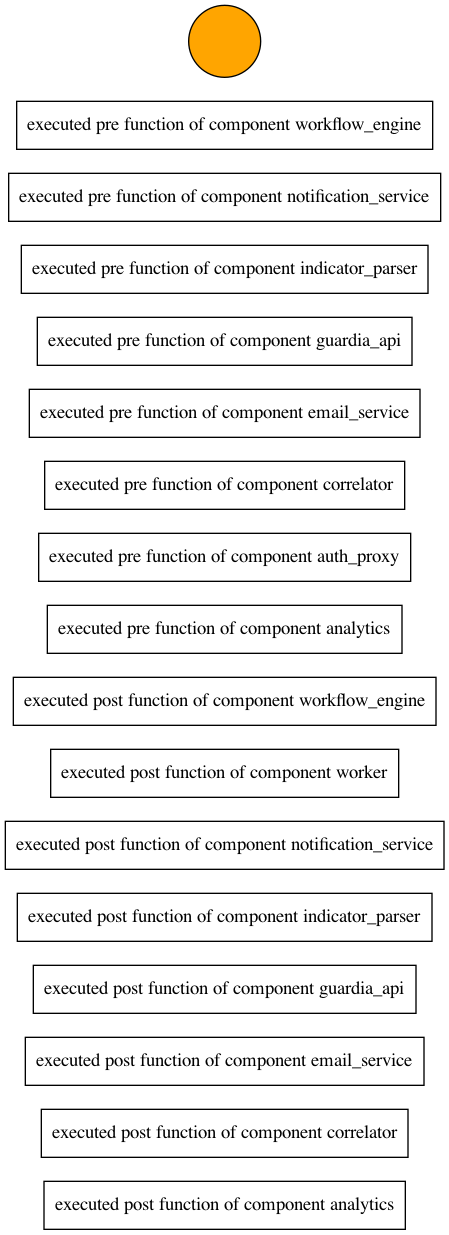

In [291]:
# Discovers a Petri net using the Alpha+ algorithm
mine2.generate_petri_net_alpha_plus()

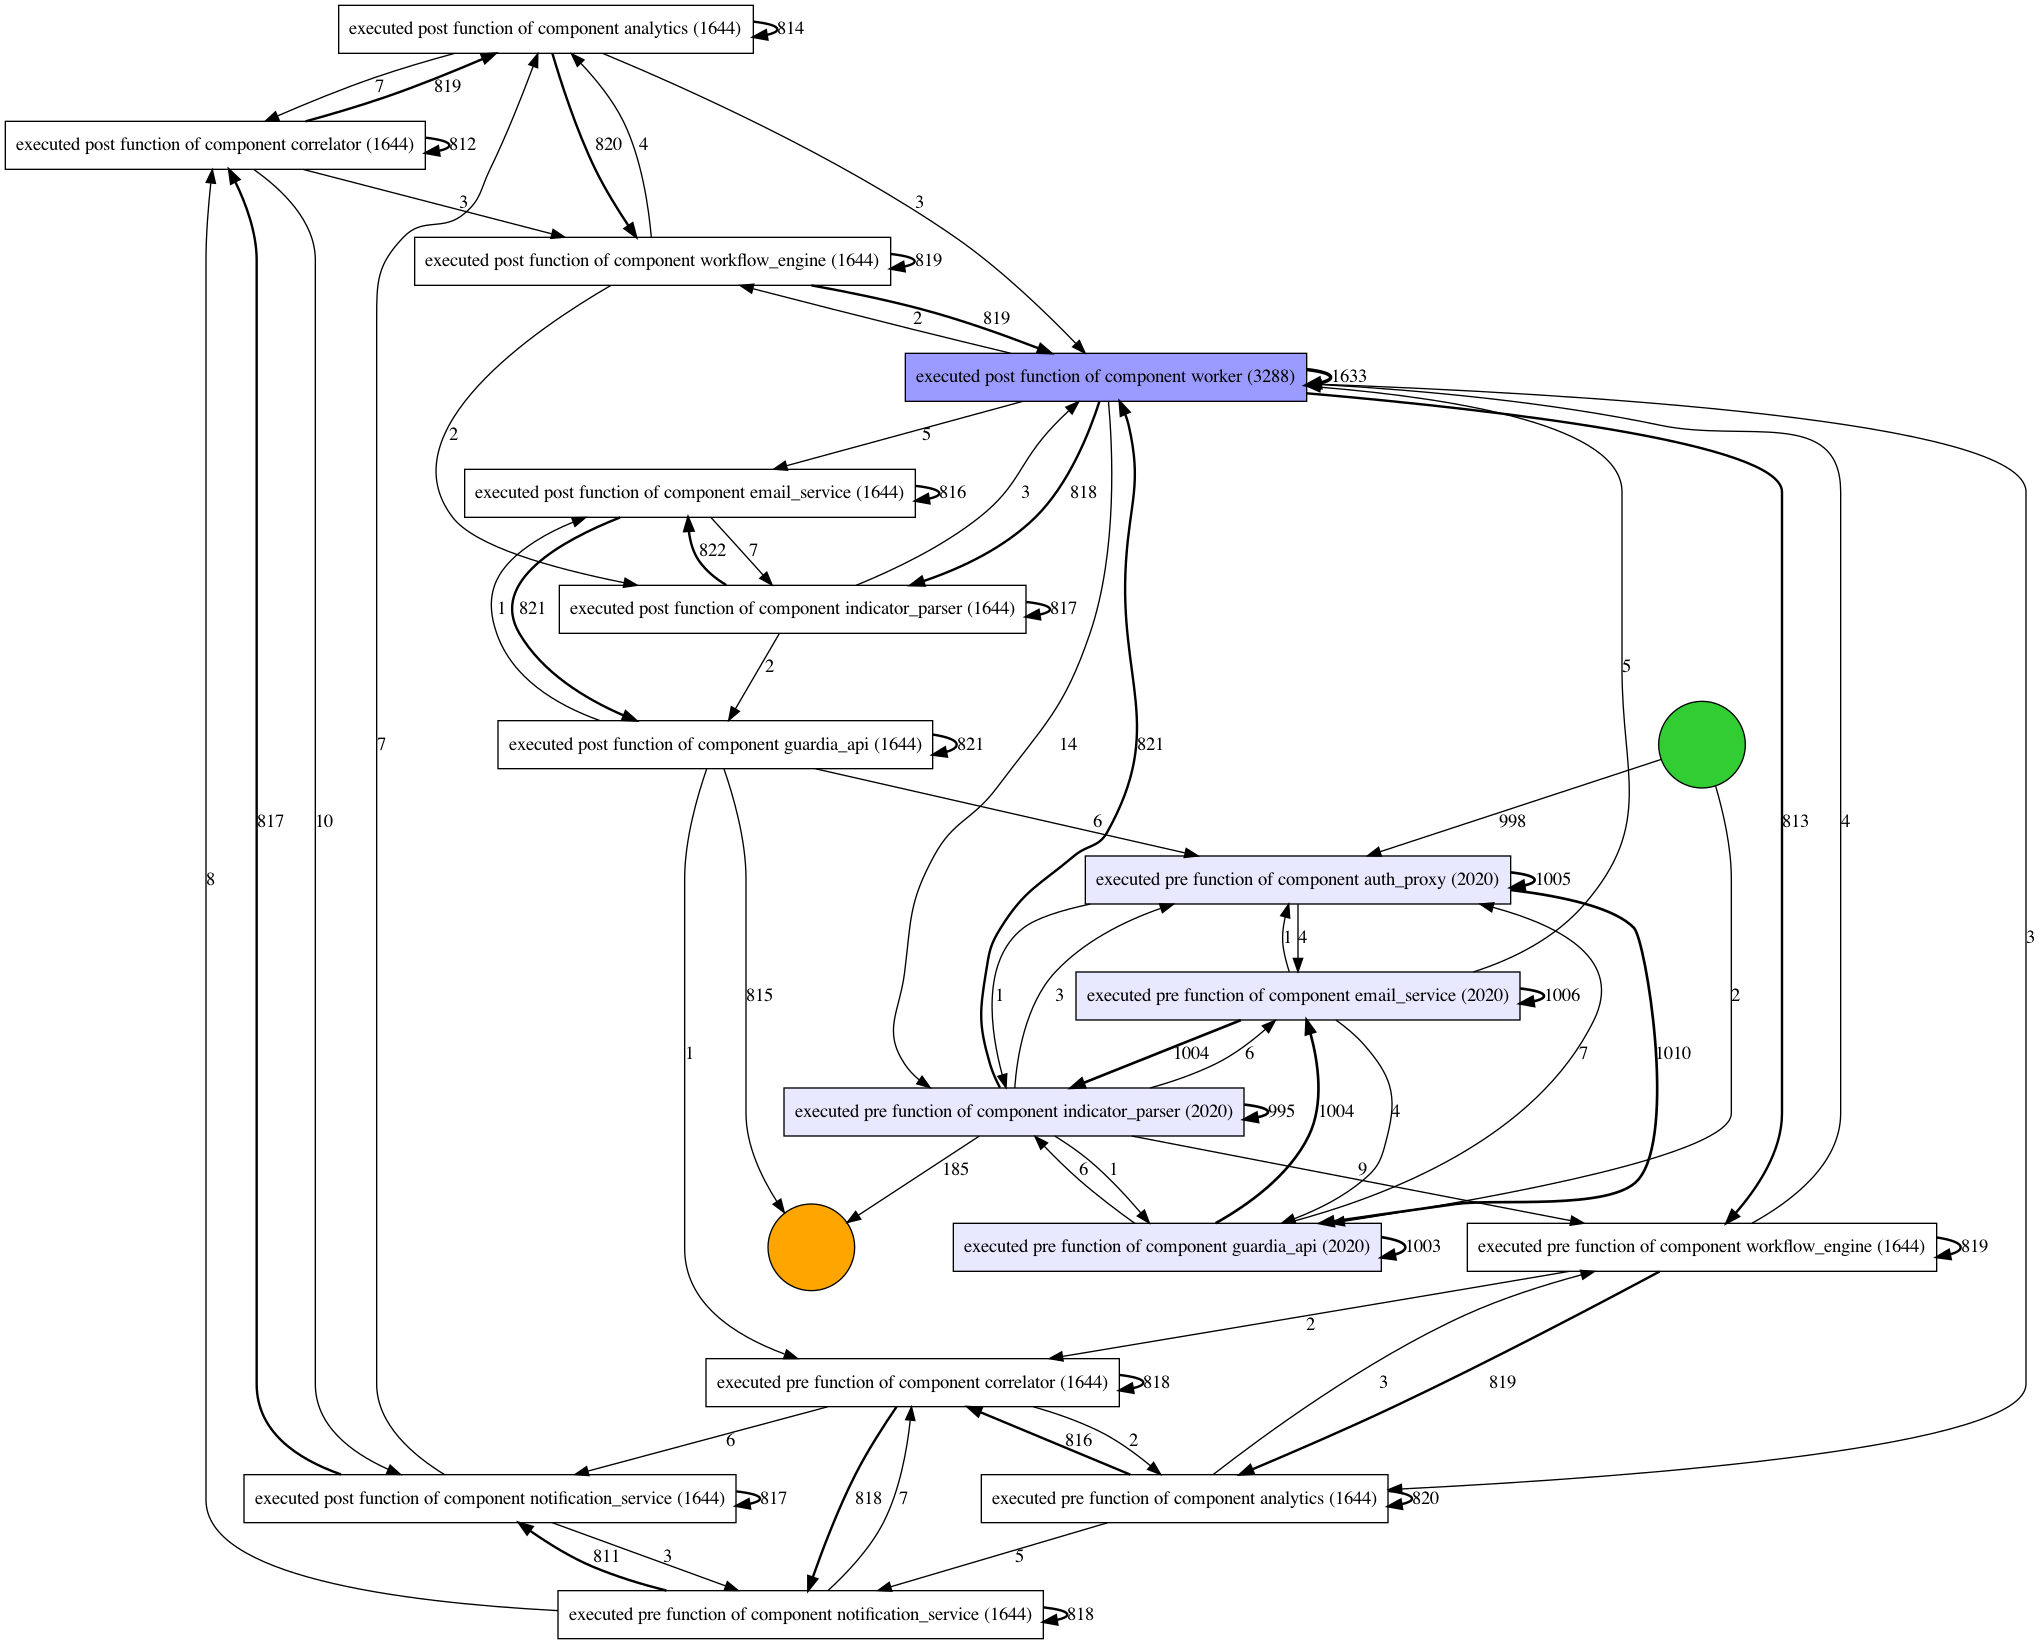

In [292]:
# Discovers a DFG from a log
mine2.directly_follows_graph()

Frequency: 


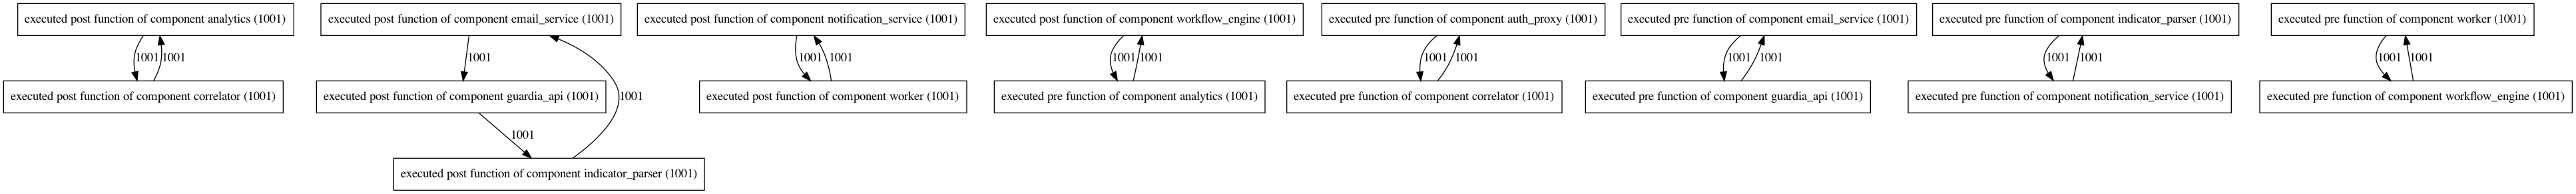

Performance: 


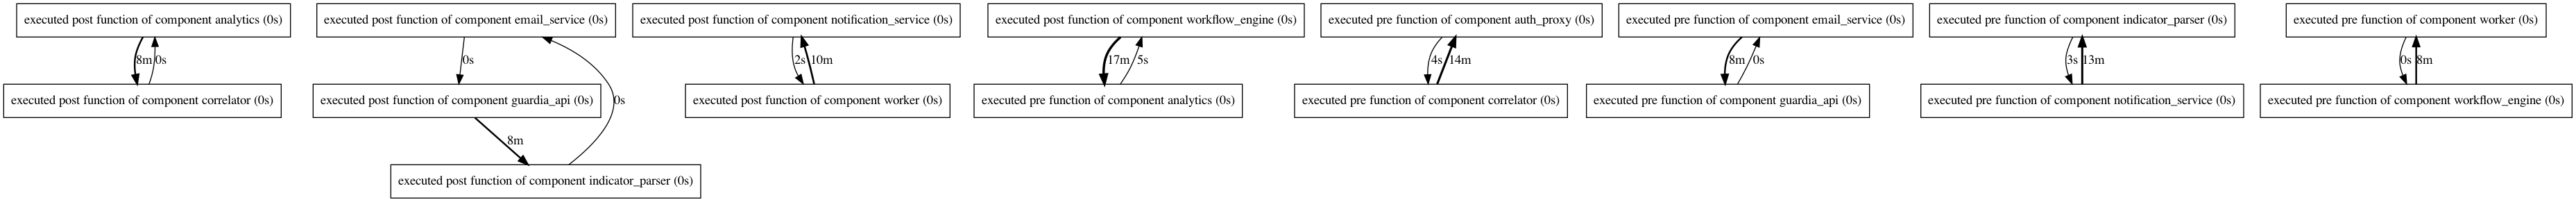

In [293]:
# Performance Graph
mine2.frequency_performance_graph()

In [294]:
# Process Replay
mine2.process_replay()

{({'executed post function of component indicator_parser'}, {'executed post function of component guardia_api'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1644, 'p': 1644}, ({'executed pre function of component workflow_engine'}, {'executed pre function of component correlator'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1644, 'p': 1644}, ({'executed pre function of component correlator'}, {'executed post function of component notification_service'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1644, 'p': 1644}, ({'executed post function of component correlator'}, {'executed post function of component workflow_engine'}): {'underfed_traces': set(), 'overfed_traces': set(), 'm': 0, 'r': 0, 'c': 1644, 'p': 1644}, start: {'underfed_traces': {{'attributes': {'concept:name': 349}, 'events': [{'time:timestamp': datetime.datetime(2021, 1, 18, 18, 47, 31, 351137, tzinfo=datetime.timezone.utc), 'concept:

In [295]:
# Diagnostics
mine2.print_diagnostics()

 Throughput Analysis: 


In [242]:
# Root Cause Analysis
# mine.root_cause_analysis()